## Environment

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_tree, plot_importance
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn import tree
import seaborn as sns

## Load Data

In [2]:
df = pd.read_csv('final_data.csv')

In [3]:
# Pre-Process
df = df.drop_duplicates()
df = df.dropna()
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [4]:
df = df.rename(columns={'case/_healthy_control/_cancer_control': 'patient', 'type': 'target'})

In [5]:
#Two-label prediction (HPV+ Cancer versus Healthy & Cancer Control)
def create_new_labels(df, old_column_name, new_column_name):
    df[new_column_name] = df[old_column_name].apply(lambda x: "HPV+ Cancer Patient" if x == "HPV+ Cancer Patient" else "Healthy Control/Cancer Control")
    return df

In [6]:
df_m2 = create_new_labels(df, 'target', 'target_2way')
df_m2 = df_m2.drop('target', axis=1)
df_m2

,patient,#_of_unique_reads,%_genome_coverage,mean_fragment_length,skew,kurtosis,target_2way
0,44 (HL10) P1,50,30.69820,171.428171,1.298403,4.023628,HPV+ Cancer Patient
1,45 (HL11) P1,768,99.93680,164.145265,0.434787,3.488924,HPV+ Cancer Patient
2,51-P1,181226,100.00000,165.152929,1.150977,2.038099,HPV+ Cancer Patient
3,54-P1,4986,99.64580,162.336460,0.080379,2.461268,HPV+ Cancer Patient
4,57-P1,18087,100.00000,171.459970,1.352784,3.621649,HPV+ Cancer Patient
...,...,...,...,...,...,...,...
301,AdditionalControl28,0,0.00000,167.132535,0.539018,2.744452,Healthy Control/Cancer Control
302,AdditionalControl29,0,0.00000,167.656947,0.977003,3.802810,Healthy Control/Cancer Control
303,AdditionalControl30,0,0.00000,177.190484,1.357161,3.298152,Healthy Control/Cancer Control
304,AdditionalControl31,0,0.00000,167.802207,1.056744,3.898798,Healthy Control/Cancer Control


In [7]:
# Normalise values (for Logistic Regression)
num_cols = df_m2.select_dtypes(include=[np.number]).columns
df_m2[num_cols] = preprocessing.MinMaxScaler().fit_transform(df_m2[num_cols])
df_m2

,patient,#_of_unique_reads,%_genome_coverage,mean_fragment_length,skew,kurtosis,target_2way
0,44 (HL10) P1,0.000062,0.306982,0.848950,0.789518,0.710541,HPV+ Cancer Patient
1,45 (HL11) P1,0.000945,0.999368,0.658041,0.455489,0.599251,HPV+ Cancer Patient
2,51-P1,0.223030,1.000000,0.684455,0.732496,0.297284,HPV+ Cancer Patient
3,54-P1,0.006136,0.996458,0.610626,0.318412,0.385360,HPV+ Cancer Patient
4,57-P1,0.022259,1.000000,0.849784,0.810551,0.626876,HPV+ Cancer Patient
...,...,...,...,...,...,...,...
301,AdditionalControl28,0.000000,0.000000,0.736347,0.495803,0.444301,Healthy Control/Cancer Control
302,AdditionalControl29,0.000000,0.000000,0.750094,0.665207,0.664582,Healthy Control/Cancer Control
303,AdditionalControl30,0.000000,0.000000,1.000000,0.812244,0.559545,Healthy Control/Cancer Control
304,AdditionalControl31,0.000000,0.000000,0.753902,0.696049,0.684560,Healthy Control/Cancer Control


In [8]:
df_m2['target_2way'] = df_m2['target_2way'].astype('category')
le = preprocessing.LabelEncoder()
df_m2['target_2way'] = le.fit_transform(df.target_2way.values)
df_m2

,patient,#_of_unique_reads,%_genome_coverage,mean_fragment_length,skew,kurtosis,target_2way
0,44 (HL10) P1,0.000062,0.306982,0.848950,0.789518,0.710541,0
1,45 (HL11) P1,0.000945,0.999368,0.658041,0.455489,0.599251,0
2,51-P1,0.223030,1.000000,0.684455,0.732496,0.297284,0
3,54-P1,0.006136,0.996458,0.610626,0.318412,0.385360,0
4,57-P1,0.022259,1.000000,0.849784,0.810551,0.626876,0
...,...,...,...,...,...,...,...
301,AdditionalControl28,0.000000,0.000000,0.736347,0.495803,0.444301,1
302,AdditionalControl29,0.000000,0.000000,0.750094,0.665207,0.664582,1
303,AdditionalControl30,0.000000,0.000000,1.000000,0.812244,0.559545,1
304,AdditionalControl31,0.000000,0.000000,0.753902,0.696049,0.684560,1


In [9]:
# Get the list of classes
classes = le.classes_
print(classes)
label_mapping = {i: label for i, label in enumerate(le.classes_)}
print(label_mapping)

['HPV+ Cancer Patient' 'Healthy Control/Cancer Control']
{0: 'HPV+ Cancer Patient', 1: 'Healthy Control/Cancer Control'}


## Modelling

In [10]:
# Training and testing sets
X = df_m2.drop('target_2way', axis=1)
y = df_m2['target_2way']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
X_test_patients = X_test['patient'].copy()

In [12]:
# Drop 'patient' column from X_train and X_test
X_train = X_train.drop('patient', axis=1)
X_test = X_test.drop('patient', axis=1)

In [13]:
# Define the models
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'NaiveBayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier()
}

In [14]:
# Define params for grid search
params = {
    'RandomForest': { 'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10] },
    'XGBoost': { 'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'learning_rate': [0.01, 0.1, 0.2, 0.3] },
    'NaiveBayes': {},
    'AdaBoost': { 'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 0.2, 0.3] }
}

In [15]:
# Grid search for hyperparameter tuning
for name in models.keys():
    model = models[name]
    param = params[name]
    gscv = GridSearchCV(model, param, cv=10, n_jobs=-1)
    gscv.fit(X_train, y_train)
    models[name] = gscv.best_estimator_

In [16]:
results = []
for name in models.keys():
    model = models[name]
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Compute AUC for classification
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    auc = roc_auc_score(y_test_bin, y_pred_bin, average='weighted', multi_class='ovr')
    
    results.append([name, accuracy, precision, recall, f1, auc])

In [17]:
# Results to csv
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_df.to_csv('model_results_2way.csv', index=False)

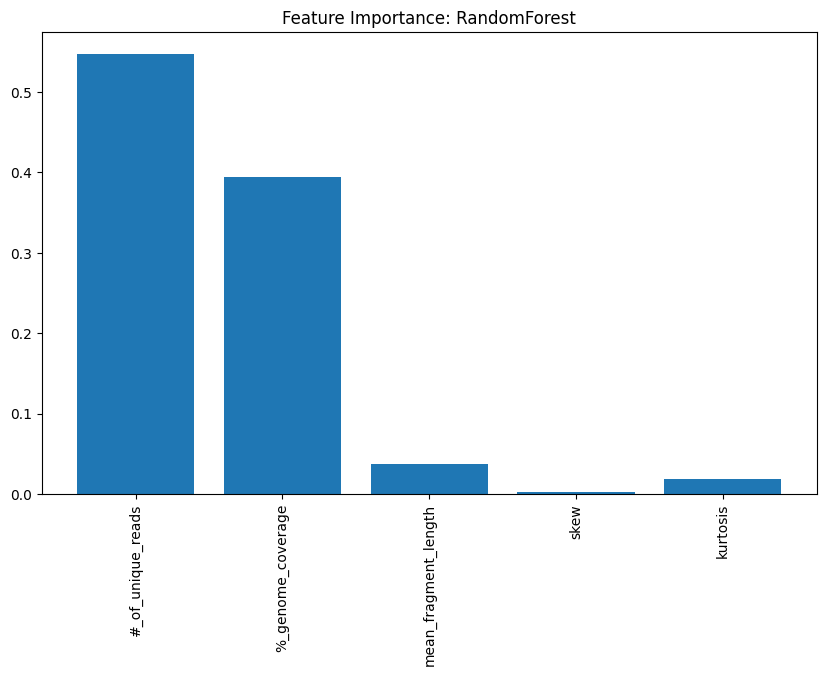

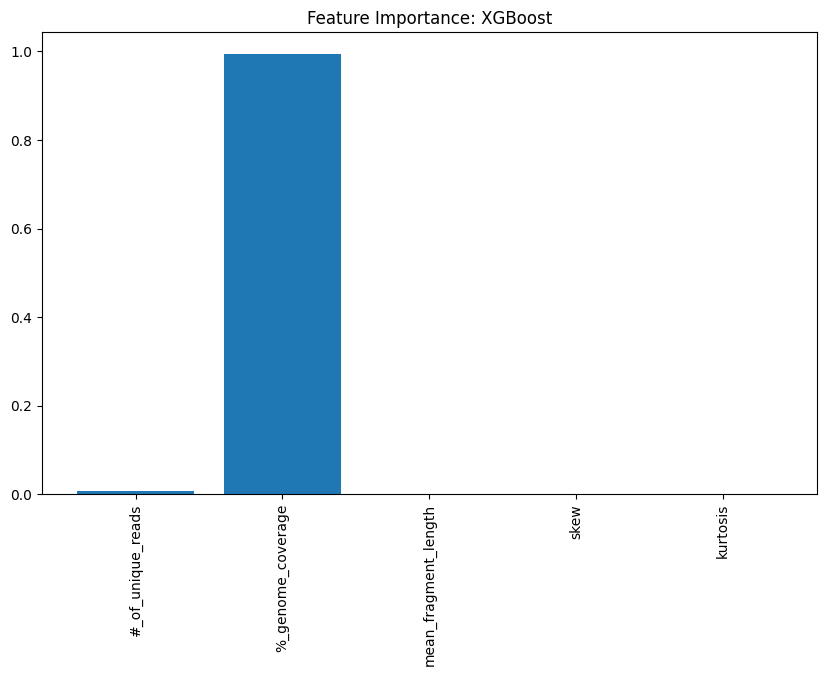

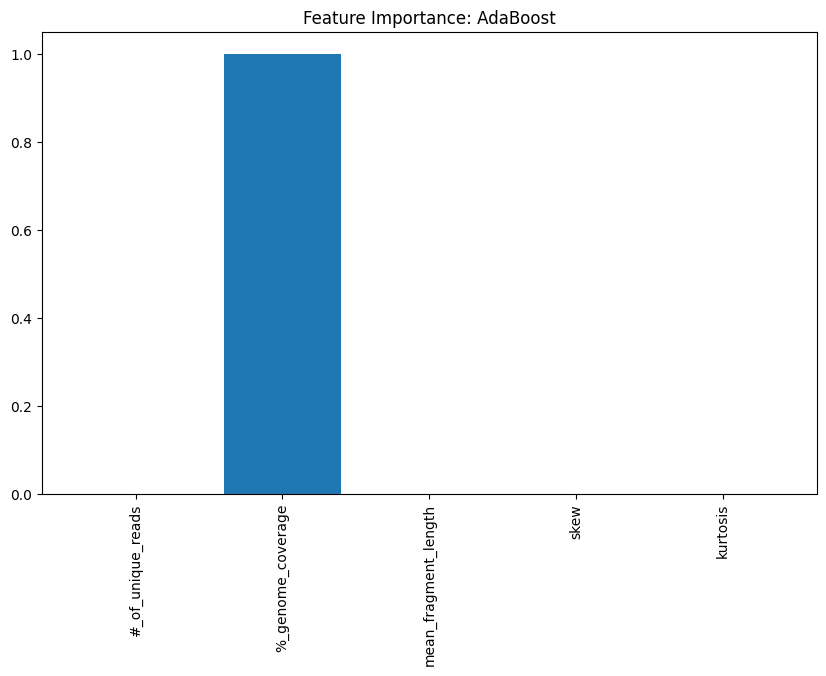

In [18]:
# Basic feature importance plots
for name in models.keys():
    if name in ['RandomForest', 'XGBoost', 'AdaBoost']:
        model = models[name]
        importance = model.feature_importances_
        
        # Ensure that the number of importances matches the number of features
        if len(importance) != X_train.shape[1]:
            print(f"Skipping {name} due to mismatch in number of features and importances")
            continue
        
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importance: {name}')
        plt.bar(X_train.columns, importance)
        plt.xticks(rotation=90)
        plt.show()


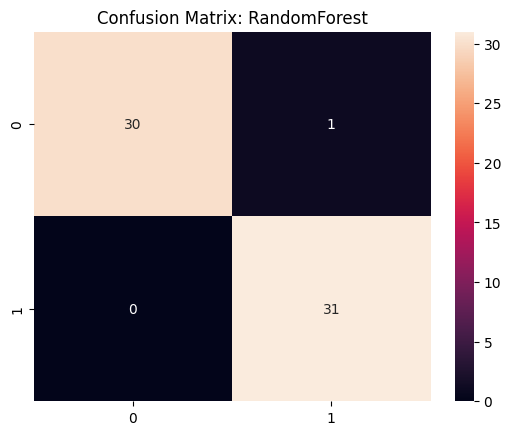

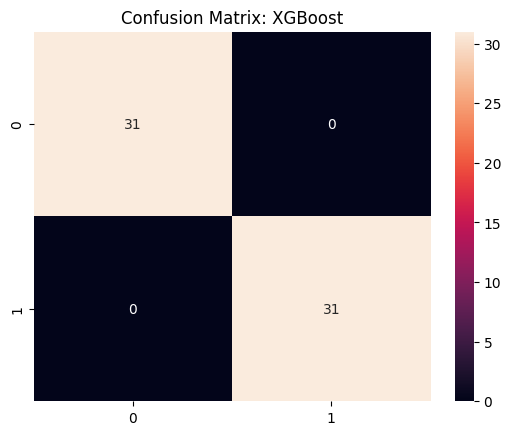

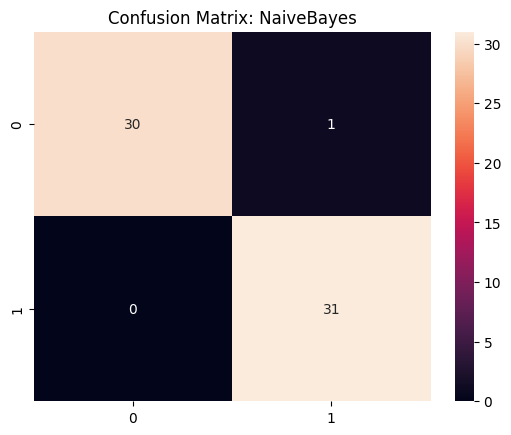

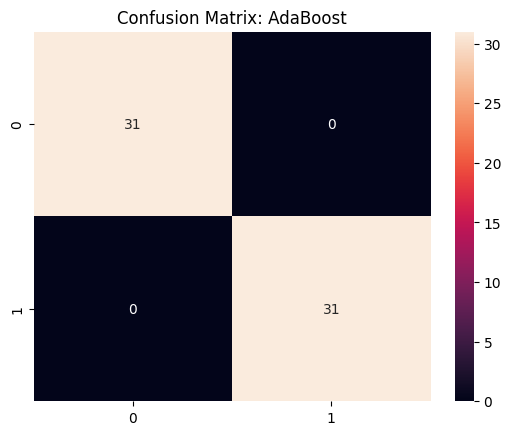

In [19]:
# Confusion matrices
for name in models.keys():
    model = models[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

In [20]:
# Finalise models by retraining on the entire dataset
for name in models.keys():
    model = models[name]
    model.fit(X_train, y_train)

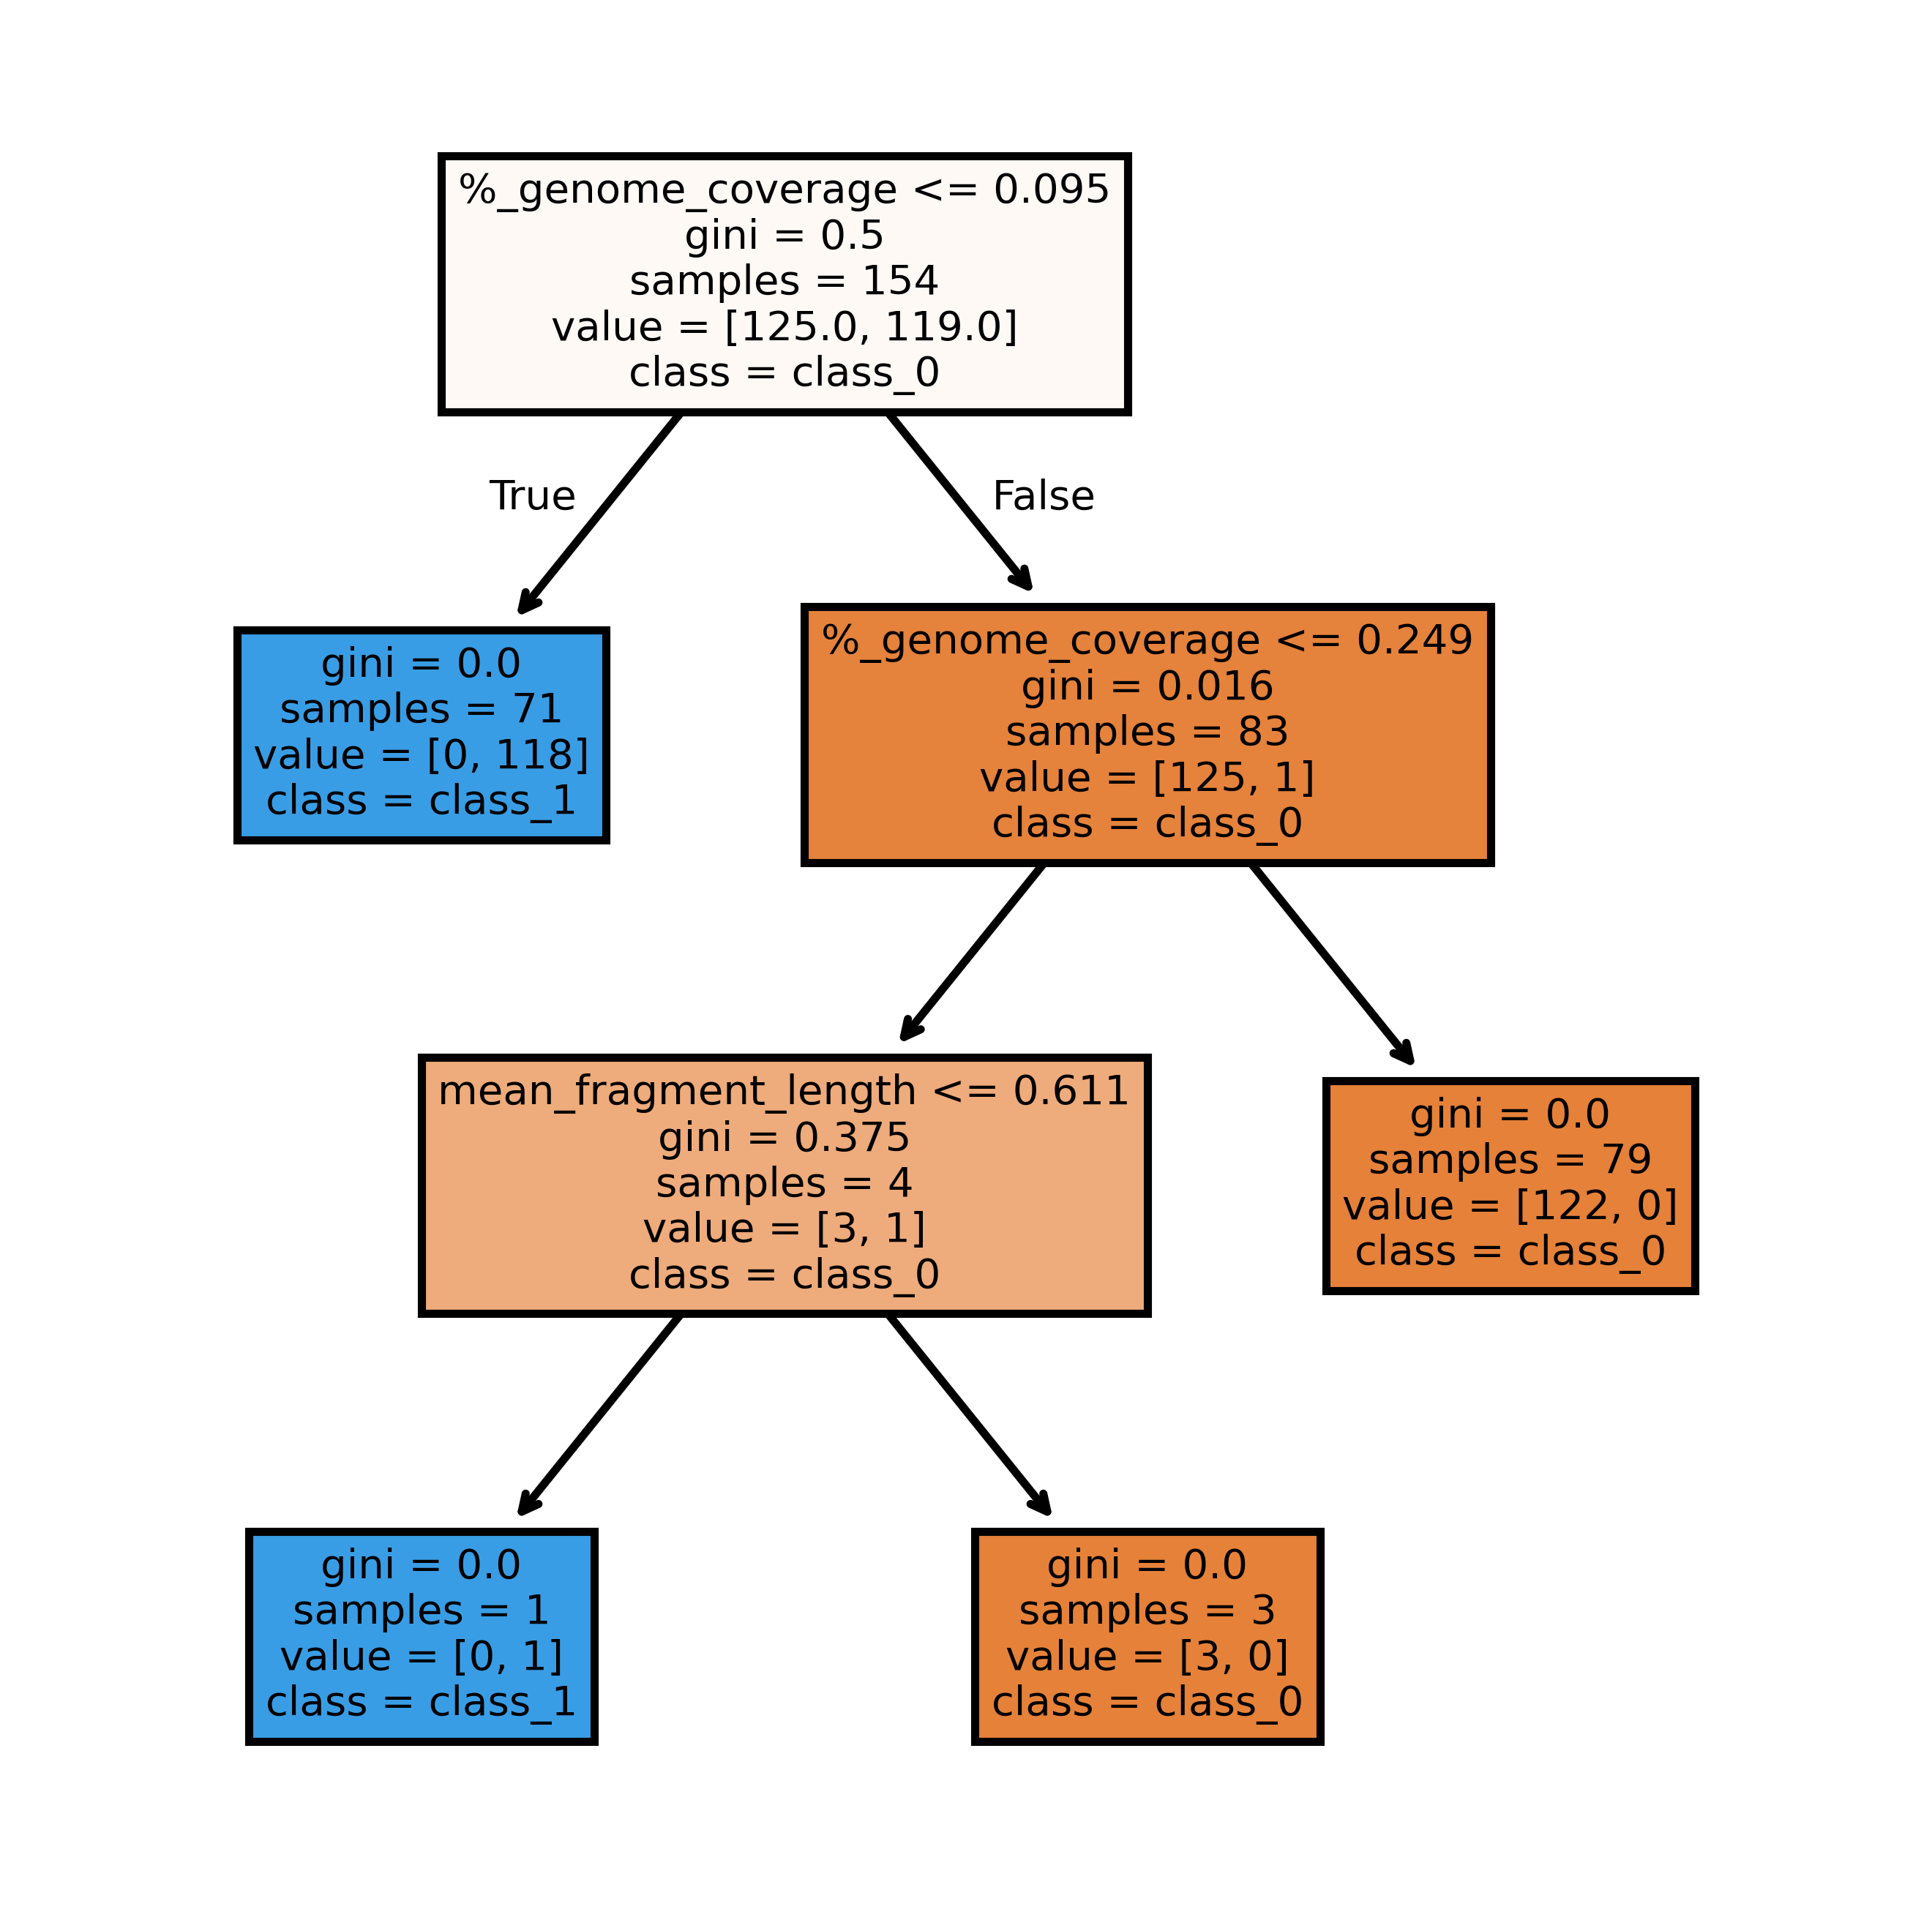

In [21]:
# RandomForest
rf_model = models['RandomForest']
rf_tree = rf_model.estimators_[0]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_tree,
               feature_names = X_train.columns.tolist(), 
               class_names=['class_0', 'class_1', 'class_2'],
               filled = True);
fig.savefig('random_forest_tree_2way.png')

In [22]:
# Bootstrap for 95% confidence intervals
n_iterations = 1000
n_size = int(len(y) * 0.50)

# Define df to store the results
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Score', 'Lower CI', 'Upper CI'])

In [26]:
# Run bootstrap
for name in models.keys():
    model = models[name]
    lb = LabelBinarizer()
    lb.fit(y_train)  # Fit the LabelBinarizer on the training set
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        stats = list()
        for i in range(n_iterations):
            # Prepare train set
            train = resample(range(len(y_train)), n_samples=n_size)
            # Fit model
            model.fit(X_train.iloc[train], y_train.iloc[train])
            # Evaluate model on the test set
            predictions = model.predict(X_test)
            if metric == 'accuracy':
                score = accuracy_score(y_test, predictions)
            elif metric == 'precision':
                score = precision_score(y_test, predictions, average='weighted')
            elif metric == 'recall':
                score = recall_score(y_test, predictions, average='weighted')
            elif metric == 'f1':
                score = f1_score(y_test, predictions, average='weighted')
            elif metric == 'auc':
                y_test_bin = lb.transform(y_test)  # Transform the labels using the fitted LabelBinarizer
                y_pred_bin = lb.transform(predictions)
                score = roc_auc_score(y_test_bin, y_pred_bin, average='weighted', multi_class='ovr')
            stats.append(score)
        # CIs
        alpha = 0.95
        p = ((1.0 - alpha) / 2.0) * 100
        lower = max(0.0, np.percentile(stats, p))
        p = (alpha + ((1.0 - alpha) / 2.0)) * 100
        upper = min(1.0, np.percentile(stats, p))
        new_row = pd.DataFrame([{
            'Model': name,
            'Metric': metric,
            'Score': np.mean(stats),
            'Lower CI': lower,
            'Upper CI': upper
        }])
        results_df = pd.concat([results_df, new_row], ignore_index=True)

/var/folders/g6/pjpjzp_j3kb43nycm7gqzw9w0000gn/T/ipykernel_19916/4005263112.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/Users/michaelbryan/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/michaelbryan/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

In [27]:
results_df.to_csv('model_CI_results_2way.csv', index=False)